# Introduction
This is an implementation / illustration of the following paper: 
    - Homography-Based Extrinsic Self-Calibration for Cameras in Automotive Applications
    - https://www.iss.uni-stuttgart.de/forschung/publikationen/miksch_wit2010.pdf
    
## Main idea
The main idea is to use the expression of a planar homography linking two image planes. This homography depends on the vehicle motion, the extrinsics and the road.
The method makes some assumptions regarding the structure of the problem (ie: flat road, fixed camera height) to derive a formulation of the planar homography that depends only on the extrinsics. The goal is then to find the extrinsics that produce the best homography matrix (ie: minimizes an error function).


## Limitations
- This method makes strong assumptions regarding the road surface as it assumes it is perfectly flat (normal vector fixed at $[0,0,-1]$). This assumption can be broken easily, even on highways.
- It also assumes a fixed camera height. In real life the car height can change globally based on speed, temperature, tire pressure, and locally based on road geometry.

Furthermore, the authors mention that the method is sensitive to camera height. 

- Another limitation, more generic, is that it is that this method relies on the estimation of the Essential matrix from feature points, which can be brittle.
- The homography error function is appearance based, however.

# Basics
## Camera model
We use the pinhole camera model and projective projection. We call 3D world points $M_w$ and 2D image points $m_p$. In homogeneous coordinates we have thus:

$m_p = A [R_e \; t_e]M_w$,
where $[R_e \; t_e]$ are the extrinsic parameters, that we aim to compute.

We consider two cooridinate systems : $WCS$ for World Coordinate System and $CCS$ for Camera Coordinate System.


Thus the intermediate step, in homogeneous coordinates, $M_c = R_eM_w + t_e$ transforms 3D points in the $WCS$ into the $CCS$. 
Then the last step is to use the intrinsics matrix $A$ to get the homogeneous image coordinates.

## Definition of $WCS$
We define the origin of $WCS$ as being on the road's surface, right below the camera center of projection (COP). The z axis of the $WCS$ points towards the camera, x towards the direction of travel (ie, ISO system).

As a result, the x and y axes describe the road surface, **which is assumed to be flat**.

## Extrinsic parameters
We already defined

- $M_c = R_eM_w + t_e$
- So the inverse is $M_w = R_e^TM_c + t_h$, with $t_h = -R_e^Tt_e$

The COP has the following coordinates:
- $M_c = 0$ in the $CCS$
- $M_w = t_h$ in the $WCS$

Where $t_h = [0,0, h_c]$ , $h_c$ being the height of the camera from the ground.

Note: since $t_h = -R_e^Tt_e$, then $t_e = -R_e t_h$.

## Motion of the vehicle
We define the motion of the vehicle as a transform in the $WCS$ : $M'_w = R_w M_w + t_w$.

## Summary
This leads us to the following relationship :

![plp.PNG](attachment:plp.PNG)

With: 
- $M_c = R_eM_w + t_e$
- $M_w = R_e^TM_c + t_h$, with $t_h = -R_e^Tt_e$
- $M'_w = R_w M_w + t_w$.

Knowing this we can find $R_c, t_c$, the transform between two camera views in $CCS$:

$$
\begin{align}
M_c' &= R_e M_w' + t_e \\
&= R_e(R_w M_w + t_w) + t_e \\
&= R_e[R_w (R_e^T M_c + t_h) + t_w] + t_e \\
&= R_e[R_w (R_e^T M_c - R_e^T T t_e) + t_w] + t_e \\
&= R_e R_w R_e^T M_c - R_e R_w R_e^T t_e + R_e t_w + t_e 
\end{align}
$$

Thus:

- $R_c = R_e R_w R_e^T$
- $t_c = R_e t_w  + t_e  - R_e R_w R_e^T t_e$

## Homography of the road surface
The homography matrix relating two camera shots for a point on the road surface is

$H_c = R_e(R_w + \frac{t_w n_w^T}{-h_c})R_e^T$.

### Derivation
We know that the homography for a plane $\pi_c$ is $H_c = R_c + \frac{t_c n_c^T}{d_c}$, where
- $R_c, t_c$ are the transform between camera views in $CCS$, as defined before,
- The plane $\pi_c: n_c^T M_c - d_c = 0$ is defined in the first image, so in $CCS$.

Now we can more a plane defined in defined in $WCS$ as $\pi_w: n_w^T M_w - d_w = 0$ by doing $\pi_c: n_w^T R_e^T M_c - (d_w + n_w^T R_e^T t_e) = 0$, thus giving us:
- $n_c^T = n_w^T R_e^T$
- $d_c = d_w + n_w^T R_e^T t_e$

We also made the following assumptions:
- $n_w = [0, 0, 1]^T$ , ie **the road is flat**,
- $d_w = 0$, ie the origin of $WCS$ is on the road,
- $R_w = \begin{bmatrix}
cos(\Delta w) & sin(\Delta w) & 0 \\
-sin(\Delta w) & cos(\Delta w) & 0 \\
0 & 0 & 1
\end{bmatrix}$, ie **the vehicle rotation between two frames is only along the Z axis**.

Remembering that $t_e = -R_e t_h$ from the previous definition, we can use these assumptions to rewrite $t_c$.

$$
\begin{align}
t_c &= R_e t_w  + t_e  - R_e R_w R_e^T t_e \\
&= R_e t_w - R_e t_h + R_e R_w R_e^T R_e t_h \\
&= R_e (R_w t_h + t_w - t_h)
\end{align}
$$

And from the third assumption, and that $t_h = [0,0, h_c]$, we get $R_w t_h = t_h$.

Thus
- $t_c = R_e t_w$

Note: 
- if the vehicle rotation was not only on the Z axis, then the third column of $R_w$ would not be $[0,0,1]$, and there would be a new coefficient to consider: $R_w t_h = \delta t_h$.

Then we can also rewrite $d_c$, using the second assumption:

$$
\begin{align}
d_c &= d_w + n_w^T R_e^T t_e \\
&= 0 +  n_w^T R_e^T t_e \\
&= -n_w^T R_e^T R_e t_h \\
&= -n_w^T t_h
\end{align}
$$

Thus 
- $d_c = -h_c$ as we assume the road is flat.

Note:
- If the road wasn't flat, d_c would depend on the value of $n_w$.

Using these definitions of $t_c, d_c, R_c, n_c$, we can compute the homography matrix.

# Calibration principle
The goal is to identify the extrinsic parameters $R_e, t_e$. Besides the vehicle motion $R_w, t_w$, they are the only unknowns in the homography matrix $H_c$. 

Therefore the goal is to find the homography matrix that fits best to the image motion on the road surface between two consecutive frames.

A homography matrix has 8 degrees of freedom, which is too much for an efficient parameter search. Therefore we will reduce the search space by using more data and the assumptions we introduced earlier.

## Use of odometric data
We use the velocity and the yaw rate of the vehicle to estimate the trajectory. *This allows us to compute $R_w and t_w$.*


Note: what if we had full 6-DOF trajectory information ?


## Estimation of the essential matrix
We compute the essential matrix between two frames and decompose it to *obtain $R_c$ and $t_c$* (up to a scale factor).


## Parametrization of the rotation matrix
We use the following relation, defined earlier : $t_c = R_e t_w$. Thus we see that $R_e$ can be defined as a specific type of rotation matrix, one that aligns a vector to another. Thus knowing $t_c$ and $t_w$ allows us to reduce the unknown DOF of $R_e$ to only 1 (instead of 3).

### Derivation
Rotation matrices which are capable to rotate one vector to another ($y = Rx$) can be parametrized with 1 DOF.

Using axis-angle, we compute the axis $v(\alpha)$, where $\alpha$ is the one unknown parameter, and the angle $\gamma$.

$$
\begin{align}
v(\alpha) &= cos(\alpha) \frac{x+y}{||x+y||} + sin(\alpha) \frac{x \times y}{||x \times y||} \\
\gamma &= arccos(\frac{p_x^T p_y}{||p_x|| ||p_y||})
\end{align}
$$

where $p_x = x - (v^T x)v$ and $p_y = y - (v^T y)v$ are projections of the vector $x$ and $y$ onto the plane whose normal vector is the rotation axis.

Note: $\alpha \in [-\pi, \pi]$.

# Summary of the method
We can reformulate the homography matrix as a function of $\alpha$: $H_c(\alpha) = R_e(\alpha)(R_w + \frac{t_w n_w^T}{-h_c})R_e^T (\alpha)$.

Then we determine the optimal $\hat \alpha = argmin e(H_c(\alpha))$ by minimizing an error function.

# Implementation

In [1]:
import numpy as np
from geometry_uvr.SE3 import SE3
import h5py
import matplotlib.pyplot as plt
import cv2 as cv
import tqdm
from scipy.spatial.transform import Rotation as R
import yaml

In [2]:
def read_visual_odom_verifier_hdf5_dump(hdf5_path):
    
    hf = h5py.File(hdf5_path, 'r')
    veh_rotations = hf.get('/vehicle_odometry/rotation')
    veh_translations = hf.get('/vehicle_odometry/translation')
    vo_rotations = hf.get('/visual_odometry/rotation')
    vo_translations = hf.get('/visual_odometry/translation')
    
    veh_poses = [SE3(veh_rotations[i], veh_translations[i]) for i in range(len(veh_rotations))]
    vo_poses = [SE3(vo_rotations[i], vo_translations[i]) for i in range(len(vo_rotations))]
    
    return vo_poses, veh_poses

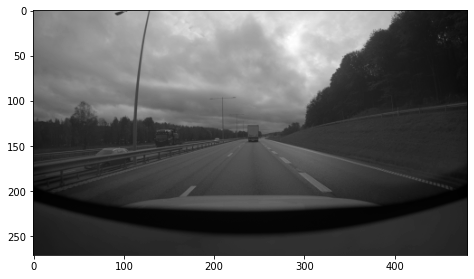

In [9]:
# 0. Prepare data
data_folder = "data/"
hdf5_path_vov = f"{data_folder}/VisualOdometryVerification.hdf5"
hdf5_path_img = f"{data_folder}/ImageDebug.hdf5"

hf = h5py.File(hdf5_path_img, 'r')

with open(f"{data_folder}/sensor.yaml", "r") as stream:
    try:
        sensor = (yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

#Intrinsics from sensor model
K = np.array(sensor["sensors"]["cameras"][0]["camera_matrix"]).reshape((3,3))

# Frames
image_idx = 200
img1 = np.array(hf.get(f"/image/data/frame{image_idx}")).squeeze()
img2 = np.array(hf.get(f"/image/data/frame{image_idx + 1}")).squeeze()

# VO Data
vo_poses, veh_poses = read_visual_odom_verifier_hdf5_dump(hdf5_path_vov)

# Display one of the images we'll work with
#cv.imwrite("data/img1.png", img1)
from matplotlib.image import imread
im = imread("data/img1.png")
plt.figure(figsize=(16*0.5,9*0.5))
plt.imshow(im, cmap = "gray")
plt.show()

In [4]:
# Modified from OpenCV example
def getEssentialMatrix(img1, img2, K):
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    return cv.findEssentialMat(pts1,pts2,K.reshape((3,3)),cv.FM_LMEDS, 0.96)[0]

In [5]:
# 1. Estimate the essential matrix, that tells us about the translation and rotation between two frames
E = getEssentialMatrix(img1, img2, K)

Rc1, Rc2, tc = cv.decomposeEssentialMat(E)
tc = tc.flatten()

iso2cv = np.array([[0., -1., 0.], [0., 0., -1.], [1., 0., 0.]])
cv2iso = iso2cv.T

tc = -cv2iso @ tc # opencv works in camCV but we work in camISO

# 2. Get Rw and tw from trajectory
pose = vo_poses[image_idx]
Rw = pose.r
tw = pose.t

# 3. Normalize the translations since we don't know the scale
#tc /= np.linalg.norm(tc)
#tw /= np.linalg.norm(tw)

print(tc, tw)

# 4. Define constants
hc = 1.6 # camera height on the car roof, in metters
nw = np.array([0,0,-1]) # plane normal in ISO

[-0.99014568  0.11859883  0.07447051] [-1.8860786  -0.00849037 -0.01350865]


In [6]:
# 3. Parametrize Re
def yRx_from_alpha(y, x, alpha):
    """
    Return the rotation matrix R(alpha) such that y = R(alpha) x for some alpha
    We use axis angle for the computation.
    """
    a = np.cos(alpha) * ((x + y) / (np.linalg.norm(x + y)))
    b = np.sin(alpha) * (np.cross(x, y) / np.linalg.norm(np.cross(x, y)))
    axis = a + b
    
    px = x - np.dot(np.dot(axis.T, x), axis)
    py = y - np.dot(np.dot(axis.T, y), axis)
    angle = np.arccos(np.dot(px.T, py) / (np.linalg.norm(px) * np.linalg.norm(py)))
    
    r = R.from_rotvec(axis * angle).as_matrix()
    
    return r
                        
def test_yRx_from_alpha():
    from scipy.spatial.transform import Rotation as R
    y = np.random.random((3))
    x = np.random.random((3))
    
    #y /= np.linalg.norm(y)
    #x /= np.linalg.norm(x)
    
    res = []
    for alpha in np.linspace(-np.pi, np.pi, 1000):
        r = yRx_from_alpha(y, x, alpha)
        yp = r @ x
        res.append(np.arccos((np.linalg.norm((np.dot(y, yp) / (np.linalg.norm(y) * np.linalg.norm(yp)))))))
      
    # Plot the error from different alphas
    plt.figure()
    plt.scatter(x = [x for x in np.linspace(-np.pi, np.pi, 1000)], y =res)
    plt.show()
    
#test_yRx_from_alpha()

In [7]:
# 5. Define the homography function
def calc_Hc(Rw, tw, nw, tc, hc, alpha):
    """
    Computes the planar homography based on the road plane and vehicle motion
    - Rw, tw: vehicle motion in world coordinates
    - nw: plane normal
    - tc: camera motion in image coordinates
    - hc: camera height in image coordinates
    """
    Re_alpha = yRx_from_alpha(tc, tw, alpha)
    
    a = Re_alpha
    b = Rw + (np.dot(tw, nw.T) / -hc)
    c = Re_alpha.T
    
    Hc_alpha = a @ b  @ c
    
    return Hc_alpha

# Define the error function
def SAD(img1, img2, B, H):
    """
    Computes the Sum of Absolute Differences between img1 and img2
    after applying the homography, over ROI B. 
    
    - B is a list of coordinates, ie where to compute the error
    """
    err = 0
    for x, y in B:
        pix1 = img1[y, x, ...]
        
        xp, yp, zp = H @ np.array([x, y, 1])
        xp /= zp
        yp /= zp
               
        try:
            pix2 = img2[int(yp), int(xp), ...]
            err += np.linalg.norm(pix2 - pix1)
        except:
            err += 100
        

    return err


def test_SAD1():
    img1 = np.zeros((5, 5, 1))
    img2 = np.zeros_like(img1)
    H = np.eye(3)
    B = np.array([[0,0]])
    print(SAD(img1, img2, B, H))
    
test_SAD1()

0.0


In [8]:
# Define the ROI B as a rectangle
xmin, xmax = 50, 320
ymin, ymax = 160, 190
B = (np.mgrid[xmin:xmax + .1:1, ymin:ymax + .1:1].reshape(2,-1).T).astype(int)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:47<00:00,  8.80it/s]


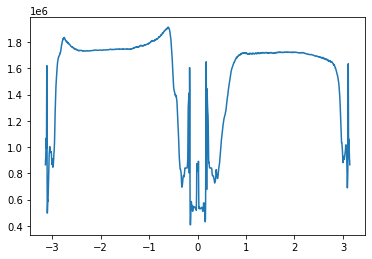

-0.14930030119611315


In [9]:
# Find the parameter alpha that produces the best homography matrix for these two images.
# We should use a proper optimization algorithm, but here we want to plot the function to
# satisfy our curiosity.
# Q: how can we be sure there is a global minimum ?
err = []
mini = np.inf
best_alpha = None
alphas = np.linspace(-np.pi, np.pi, 2000)
for alpha in tqdm.tqdm(alphas):
    Hc = calc_Hc(Rw, tw, nw, tc, hc, alpha)
    Hc = Hc / Hc[-1,-1]
    
    e = SAD(img1, img2, B, Hc)
    err.append(e)
    if e < mini:
        mini = e
        best_alpha = alpha
                 
plt.figure()
plt.plot([x for x in alphas], err)
plt.show()  

print(best_alpha)

In [11]:
# Using alpha, reconstruct the extrinsics matrix Re and extract the angle from it.
Re_opti = yRx_from_alpha(tc, tw, -2)
r2 = R.from_matrix(Re_opti)
r2.as_euler("zyx", degrees = True) # yaw pitch roll

array([ 7.16329115, -4.58555634,  4.14434792])